In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
from scipy.io import loadmat
#datas = loadmat("/content/gdrive/My Drive/pattern/pattern2019/CD_PD.mat", squeeze_me=True)
datas = loadmat("/content/gdrive/My Drive/CD_PD_data/CD_PD.mat", squeeze_me=True)
#squeeze_me remove redundant dimensions

Below is all the data per subject


1.   age
2.   date (date of data collection)
3.   duration
4.   ed
5.    gender
6.    side
7.    TMSE
8.    t
9.    x
10.    y
11.    p
12.    pt
13.    diagnosis
14.    clock_drawing

#CD_PD_Data

#0. Import

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2

# 1. Making Dataframe

In [ ]:
data = pd.DataFrame(data = datas['dat'],dtype=int) 

In [ ]:
data.dtypes

age               int64
date             object
duration          int64
ed               object
gender           object
side             object
TMSE              int64
t                object
x                object
y                object
p                object
pt               object
diagnosis         int64
clock_drawing     int64
dtype: object

<PIL.Image.Image image mode=L size=800x800 at 0x7F5454946A58>


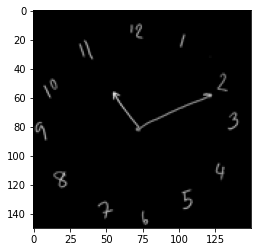

In [ ]:
# Generate Clock Drawing image 0
x0 = data['x'][0]
y0 = data['y'][0]
pt0 = data['pt'][0]
p0 = data['p'][0]
image_0 = Image.new(mode='L', size=(800, 800))
draw = ImageDraw.Draw(image_0)
for i in range(1, x0.size):
    if pt0[i]!=1:
      shape = [(int(x0[i-1]), int(y0[i-1])), (int(x0[i]), int(y0[i]))]
      draw.line(shape, fill=int(255*p0[i]), width=5) 
print(image_0)
plt.imshow(np.asarray(image_0.resize((150,150))), cmap='gray', vmin=0, vmax=255)

In [ ]:
# Generate all Clock Drawing
clock_image = []
clock_image2 = []
clock_image_x = []
#print(len(data.index))
#print(data.iloc[195]['age']!=0)
for j in range (len(data.index)):
  xi = data['x'][j]
  yi = data['y'][j]
  pti = data['pt'][j]
  pi = data['p'][j]
  image_i = Image.new(mode='L', size=(800, 800))
  draw = ImageDraw.Draw(image_i)
  for i in range(1, xi.size):
    if pti[i]!=1:
      shape = [(int(xi[i-1]), int(yi[i-1])), (int(xi[i]), int(yi[i]))]
      draw.line(shape, fill=int(255*pi[i]), width=5)
  image_i = image_i.resize((150,150))
  if data.iloc[j]['age']!=0 and data.iloc[j]['TMSE']!=0:
    clock_image_x.append(np.asarray(image_i)/255)
  clock_image.append(np.asarray(image_i)/255)
#print(len(clock_image))
#print(len(clock_image_x))
data['clock_image'] = clock_image
clock_image2 = np.array(clock_image_x)
print(clock_image[0])
print(clock_image2[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Change time format : use only the last one
new_time = []
for i in data['t']:
  new_time.append(i[-1])
data = data.drop(labels='t',axis=1)
data['t'] = new_time

In [ ]:
# Change ed format : use only the number
new_ed = []
for i in data['ed']:
  new_ed.append(int(i[0]))
data = data.drop(labels='ed',axis=1)
data['ed'] = new_ed

In [ ]:
# Change gender format : use only the number
new_gender = []
for i in data['gender']:
  new_gender.append(int(i[0]))
data = data.drop(labels='gender',axis=1)
data['gender'] = new_gender

In [ ]:
# Change side format : use only the number
new_side = []
for i in data['side']:
  new_side.append(int(i[0]))
data = data.drop(labels='side',axis=1)
data['side'] = new_side

In [ ]:
# Add date and month of data collection to features
dates = []
month = []
for i in data['date']:
  j = i.split('/')
  dates.append(int(j[0]))
  month.append(int(j[1]))
data['dates'] = dates
data['month'] = month
data = data.drop(labels='date',axis=1)

In [ ]:
# Add pen pressure mean and pressure std to features 
pressure_mean = []
pressure_std = []
for i in data['p']:
  pressure_mean.append(float(i.mean()))
  pressure_std.append(float(i.std()))
data['pressure_mean'] = pressure_mean
data['pressure_std'] = pressure_std
data = data.drop(labels='p',axis=1)

In [ ]:
# Add TMSE pass or failed (1 mean pass / 0 mean failed)
TMSE_pass = []
#print(len(data.index))
#print(data.iloc[0]['age'])
for i in range (len(data.index)):
  if data.iloc[i]['age']<=4:
    if data.iloc[i]['TMSE']>=19:
      TMSE_pass.append(1);
    else:
      TMSE_pass.append(0);
  elif data.iloc[i]['age']>=5 and data.iloc[i]['age']<=8:
    if data.iloc[i]['TMSE']>=23:
      TMSE_pass.append(1);
    else:
      TMSE_pass.append(0);
  elif data.iloc[i]['age']>=9 and data.iloc[i]['age']<=12:
    if data.iloc[i]['TMSE']>=27:
      TMSE_pass.append(1);
    else:
      TMSE_pass.append(0);
  else:
    if data.iloc[i]['TMSE']>=29:
      TMSE_pass.append(1);
    else:
      TMSE_pass.append(0);
data['TMSE_pass'] = TMSE_pass
data.head()

,age,duration,TMSE,x,y,pt,diagnosis,clock_drawing,clock_image,t,ed,gender,side,dates,month,pressure_mean,pressure_std,TMSE_pass
0,45,0,0,"[653.4375, 646.0667, 647.625, 362.64642, 362.7...","[171.75, 171.75, 171.75, 54.778854, 59.935043,...","[1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, ...",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000525,4,1,1,16,9,0.646490,0.215372,0
1,64,0,30,"[17.39536, 13.801709, 4.9477825, 3.229079, 4.2...","[684.9287, 682.58496, 678.10583, 675.97046, 67...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000810,5,0,1,29,9,0.554421,0.268971,1
2,50,0,28,"[370.40662, 370.40662, 370.30246, 370.30246, 3...","[69.57036, 69.57036, 68.47662, 68.47662, 68.47...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.001322,4,1,1,29,9,0.461746,0.187786,0
3,67,0,30,"[370.51077, 370.40662, 370.40662, 370.40662, 3...","[64.51834, 63.42459, 63.42459, 63.42459, 63.42...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000685,4,1,1,30,9,0.697002,0.256922,1
4,64,0,26,"[353.7404, 353.7404, 353.7404, 353.7404, 353.7...","[63.94542, 63.94542, 63.94542, 63.94542, 63.94...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000844,2,1,1,23,9,0.513891,0.188936,0


In [ ]:
# Remove x , y , pt , duration
data = data.drop(labels = ['x','y','pt','duration'],axis=1) 
data.head()

,age,TMSE,diagnosis,clock_drawing,clock_image,t,ed,gender,side,dates,month,pressure_mean,pressure_std,TMSE_pass
0,45,0,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000525,4,1,1,16,9,0.646490,0.215372,0
1,64,30,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000810,5,0,1,29,9,0.554421,0.268971,1
2,50,28,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.001322,4,1,1,29,9,0.461746,0.187786,0
3,67,30,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000685,4,1,1,30,9,0.697002,0.256922,1
4,64,26,1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000844,2,1,1,23,9,0.513891,0.188936,0


In [ ]:
data.dtypes

age                int64
TMSE               int64
diagnosis          int64
clock_drawing      int64
clock_image       object
t                float64
ed                 int64
gender             int64
side               int64
dates              int64
month              int64
pressure_mean    float64
pressure_std     float64
TMSE_pass          int64
dtype: object

In [ ]:
# Remove missing ages and TMSE
data = data[data['age']!=0]
data = data[data['TMSE']!=0]

#2.Classification

#2.1 Use all features

In [ ]:
# Divide data into train and test part 
X = data[['TMSE','clock_drawing','t','ed','gender','side','age','dates','month','pressure_mean','pressure_std','TMSE_pass']]
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('Accuracy of KNeighborsClassifier : {:.4f}'.format(knn.score(X_test, y_test))) # Accuracy of classifier
print('F1 score of KNeighborsClassifier: {:.4f}'.format(f1_score(y_test,knn_pred))) # F1 Score

Accuracy of KNeighborsClassifier : 0.8182
F1 score of KNeighborsClassifier: 0.8710


In [ ]:
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
print(log_reg_pred)
print(len(log_reg_pred))
# print(y_test)
print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

[1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1
 1 1 0 1 1 1 1]
44
44
Accuracy of Logistic Regression on training set: 0.8182
Accuracy of Logistic Regression on test set: 0.7727
F1 score of Logistic Regression: 0.8276


In [ ]:
# Support Vector Machines
clf = LinearSVC().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'.format(clf.score(X_train, y_train))) # Training Score
print('Accuracy of Linear SVC classifier on test set: {:.4f}'.format(clf.score(X_test, y_test))) # Testing Score
print('F1 score of Linear SVC classifier: {:.4f}'.format(f1_score(y_test,clf_pred))) # F1 Score

Accuracy of Linear SVC classifier on training set: 0.8106
Accuracy of Linear SVC classifier on test set: 0.7500
F1 score of Linear SVC classifier: 0.8136


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.8939
Accuracy of RBF-kernel SVC on test set: 0.7727
F1 score of RBF-kernel SVC: 0.8333


In [ ]:
# Cross Validation
clf3 = KNeighborsClassifier()
clfs3 = clf3.fit(X_train, y_train)
clf3_pred = clfs3.predict(X_test)
print('Accuracy of Cross Validation on training set: ' + str(cross_val_score(clf3, X_train, y_train)))
print('Mean of Cross Validation on training set: {:.4f}'.format(np.mean(cross_val_score(clf3, X_train, y_train)))) # Training Score
print('Accuracy of Cross Validation on test set: ' + str(cross_val_score(clf3, X_test, y_test)))
print('Mean of Cross Validation on test set: {:.4f}'.format(np.mean(cross_val_score(clf3, X_test, y_test)))) # Testing Score
print('F1 score of DT classifier: {:.4f}'.format(f1_score(y_test,clf3_pred))) # F1 Score

Accuracy of Cross Validation on training set: [0.77777778 0.66666667 0.73076923 0.61538462 0.80769231]
Mean of Cross Validation on training set: 0.7197
Accuracy of Cross Validation on test set: [0.77777778 0.77777778 0.66666667 0.77777778 0.625     ]
Mean of Cross Validation on test set: 0.7250
F1 score of DT classifier: 0.8710


In [ ]:
# Decision Trees
clf4 = DecisionTreeClassifier().fit(X_train, y_train)
clf4_pred = clf4.predict(X_test)
print('Accuracy of DT classifier on training set: {:.2f}'.format(clf4.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'.format(clf4.score(X_test, y_test)))
print('F1 score of DT classifier: {:.4f}'.format(f1_score(y_test,clf4_pred))) # F1 Score

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.89
F1 score of DT classifier: 0.9180


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[10  3]
 [ 7 24]]
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        13
           1       0.89      0.77      0.83        31

    accuracy                           0.77        44
   macro avg       0.74      0.77      0.75        44
weighted avg       0.80      0.77      0.78        44

Kernelized Support Vector Machines 
 [[ 9  4]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.86      0.81      0.83        31

    accuracy                           0.77        44
   macro avg       0.73      0.75      0.74        44
weighted avg       0.78      0.77      0.78        44



In [ ]:
# Naive Bayes Classifier
nbclf = GaussianNB().fit(X_train, y_train)
nbclf_pred = nbclf.predict(X_test)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'.format(nbclf.score(X_test, y_test)))
print('F1 score of GaussianNB classifier: {:.4f}'.format(f1_score(y_test,nbclf_pred))) # F1 Score

Accuracy of GaussianNB classifier on training set: 0.7879
Accuracy of GaussianNB classifier on test set: 0.8182
F1 score of GaussianNB classifier: 0.8667


In [ ]:
# Random Forest
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf_pred = rfclf.predict(X_test)
print('Accuracy of RF classifier on training set: {:.4f}'.format(rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.4f}'.format(rfclf.score(X_test, y_test)))
print('F1 score of RF classifier: {:.4f}'.format(f1_score(y_test,rfclf_pred))) # F1 Score

Accuracy of RF classifier on training set: 1.0000
Accuracy of RF classifier on test set: 0.7955
F1 score of RF classifier: 0.8475


In [ ]:
# Gradient-boosted decision trees # Overfit data
gbclf = GradientBoostingClassifier().fit(X_train, y_train)
gbclf_pred = rfclf.predict(X_test)
print('Accuracy of GBDT classifier on training set: {:.4f}'.format(gbclf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'.format(gbclf.score(X_test, y_test)))
print('F1 score of GBDT classifier: {:.4f}'.format(f1_score(y_test,gbclf_pred))) # F1 Score

Accuracy of GBDT classifier on training set: 1.0000
Accuracy of GBDT classifier on test set: 0.8864
F1 score of GBDT classifier: 0.8475


In [ ]:
# Neural Network
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
nclf = MLPClassifier().fit(X_train_scaled, y_train)
nclf_pred = nclf.predict(X_test)
print('Accuracy of NN classifier on training set: {:.4f}'.format(nclf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'.format(nclf.score(X_test_scaled, y_test)))
print('F1 score of NN classifier: {:.4f}'.format(f1_score(y_test,nclf_pred))) # F1 Score

Accuracy of NN classifier on training set: 0.7955
Accuracy of NN classifier on test set: 0.7500
F1 score of NN classifier: 0.8276


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['TMSE','clock_drawing','t','ed','gender','side','age','dates','month','pressure_mean','pressure_std','TMSE_pass']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC = []
f1_score_per_fold_SVC = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7222222222222222 F1 Score 0.7368421052631577
Fold No : 2
Accuracy 0.8888888888888888 F1 Score 0.9090909090909091
Fold No : 3
Accuracy 0.7777777777777778 F1 Score 0.8181818181818182
Fold No : 4
Accuracy 0.7777777777777778 F1 Score 0.8571428571428571
Fold No : 5
Accuracy 0.6666666666666666 F1 Score 0.7
Fold No : 6
Accuracy 0.6666666666666666 F1 Score 0.7272727272727273
Fold No : 7
Accuracy 0.5294117647058824 F1 Score 0.42857142857142855
Fold No : 8
Accuracy 0.7058823529411765 F1 Score 0.761904761904762
Fold No : 9
Accuracy 0.7058823529411765 F1 Score 0.8
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.6666666666666666


In [ ]:
accuracy_per_fold_SVC = np.array(accuracy_per_fold_SVC)
f1_score_per_fold_SVC = np.array(f1_score_per_fold_SVC)
print(f'Accuracy Score for KFold with SVC: {accuracy_per_fold_SVC.mean()} +- {accuracy_per_fold_SVC.std()}')
print(f'F1 Score for KFold with SVC: {f1_score_per_fold_SVC.mean()} +- {f1_score_per_fold_SVC.std()}')

Accuracy Score for KFold with SVC: 0.7147058823529412 +- 0.08805415927248597
F1 Score for KFold with SVC: 0.7405673274094327 +- 0.1251561703837522


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr = []
f1_score_per_fold_lr = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr.append(f1_score(y_pred, y_test))
  fold_no += 1

In [ ]:
accuracy_per_fold_lr = np.array(accuracy_per_fold_lr)
f1_score_per_fold_lr = np.array(f1_score_per_fold_lr)
print(f'Accuracy Score for KFold with lr: {accuracy_per_fold_lr.mean()} +- {accuracy_per_fold_lr.std()}')
print(f'F1 Score for KFold with lr: {f1_score_per_fold_lr.mean()} +- {f1_score_per_fold_lr.std()}')

Accuracy Score for KFold with lr: 0.7454248366013072 +- 0.07310991446079278
F1 Score for KFold with lr: 0.7904009205473737 +- 0.07274279303201678


#2.2 Using some important features

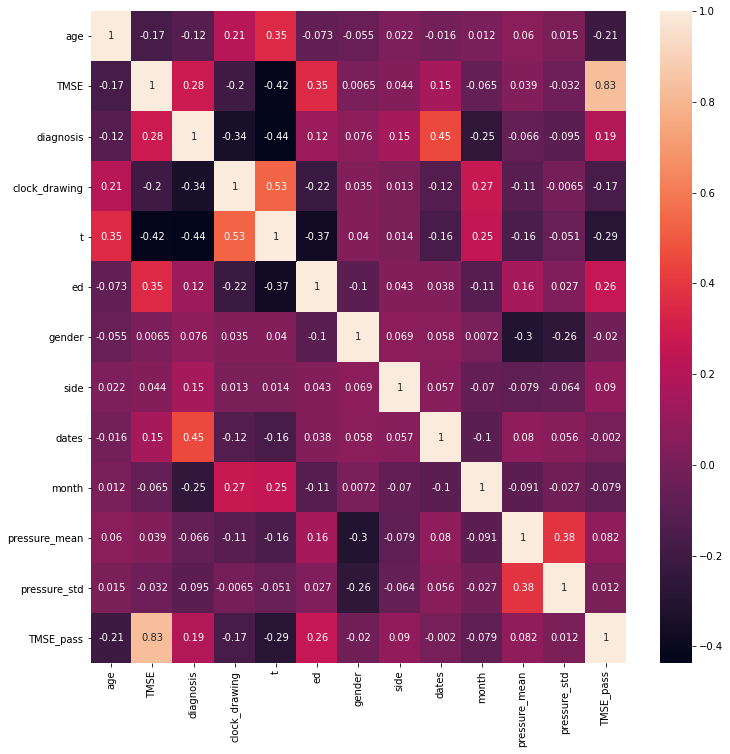

In [ ]:
# Using Heatmap to determine what features should we use
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(), annot=True)

# 2.2.1 'clock_drawing', 't', 'dates'

In [ ]:
# We will use 'clock_drawing', 't', 'dates' features to predict (most top 3 relation between 'diagnosis' and features)
# Divide data into train and test part 
X = data[['clock_drawing','t','dates']]
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print('Accuracy of KNeighborsClassifier : {:.4f}'.format(knn.score(X_test, y_test))) # Accuracy of classifier
print('F1 score of KNeighborsClassifier: {:.4f}'.format(f1_score(y_test,knn_pred))) # F1 Score

Accuracy of KNeighborsClassifier : 0.7727
F1 score of KNeighborsClassifier: 0.8276


In [ ]:
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
# print(y_test)
# print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

Accuracy of Logistic Regression on training set: 0.7500
Accuracy of Logistic Regression on test set: 0.8636
F1 score of Logistic Regression: 0.8966


In [ ]:
# Support Vector Machines
clf = LinearSVC().fit(X_train, y_train)
clf_pred = clf.predict(X_test)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'.format(clf.score(X_train, y_train))) # Training Score
print('Accuracy of Linear SVC classifier on test set: {:.4f}'.format(clf.score(X_test, y_test))) # Testing Score
print('F1 score of Linear SVC classifier: {:.4f}'.format(f1_score(y_test,clf_pred))) # F1 Score

Accuracy of Linear SVC classifier on training set: 0.7500
Accuracy of Linear SVC classifier on test set: 0.8636
F1 score of Linear SVC classifier: 0.8929


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.7424
Accuracy of RBF-kernel SVC on test set: 0.8864
F1 score of RBF-kernel SVC: 0.9123


In [ ]:
# Cross Validation
clf3 = KNeighborsClassifier()
clfs3 = clf3.fit(X_train, y_train)
clf3_pred = clfs3.predict(X_test)
print('Accuracy of Cross Validation on training set: ' + str(cross_val_score(clf3, X_train, y_train)))
print('Mean of Cross Validation on training set: {:.4f}'.format(np.mean(cross_val_score(clf3, X_train, y_train)))) # Training Score
print('Accuracy of Cross Validation on test set: ' + str(cross_val_score(clf3, X_test, y_test)))
print('Mean of Cross Validation on test set: {:.4f}'.format(np.mean(cross_val_score(clf3, X_test, y_test)))) # Testing Score
print('F1 score of DT classifier: {:.4f}'.format(f1_score(y_test,clf3_pred))) # F1 Score

Accuracy of Cross Validation on training set: [0.66666667 0.7037037  0.53846154 0.65384615 0.73076923]
Mean of Cross Validation on training set: 0.6587
Accuracy of Cross Validation on test set: [0.77777778 0.88888889 0.77777778 0.77777778 0.625     ]
Mean of Cross Validation on test set: 0.7694
F1 score of DT classifier: 0.8276


In [ ]:
# Decision Trees
clf4 = DecisionTreeClassifier().fit(X_train, y_train)
clf4_pred = clf4.predict(X_test)
print('Accuracy of DT classifier on training set: {:.2f}'.format(clf4.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'.format(clf4.score(X_test, y_test)))
print('F1 score of DT classifier: {:.4f}'.format(f1_score(y_test,clf4_pred))) # F1 Score

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.84
F1 score of DT classifier: 0.8772


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[12  1]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.96      0.84      0.90        31

    accuracy                           0.86        44
   macro avg       0.83      0.88      0.85        44
weighted avg       0.89      0.86      0.87        44

Kernelized Support Vector Machines 
 [[13  0]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       1.00      0.84      0.91        31

    accuracy                           0.89        44
   macro avg       0.86      0.92      0.88        44
weighted avg       0.92      0.89      0.89        44



In [ ]:
# Naive Bayes Classifier
nbclf = GaussianNB().fit(X_train, y_train)
nbclf_pred = nbclf.predict(X_test)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'.format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'.format(nbclf.score(X_test, y_test)))
print('F1 score of GaussianNB classifier: {:.4f}'.format(f1_score(y_test,nbclf_pred))) # F1 Score

Accuracy of GaussianNB classifier on training set: 0.7348
Accuracy of GaussianNB classifier on test set: 0.8182
F1 score of GaussianNB classifier: 0.8667


In [ ]:
# Random Forest
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf_pred = rfclf.predict(X_test)
print('Accuracy of RF classifier on training set: {:.4f}'.format(rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.4f}'.format(rfclf.score(X_test, y_test)))
print('F1 score of RF classifier: {:.4f}'.format(f1_score(y_test,rfclf_pred))) # F1 Score

Accuracy of RF classifier on training set: 1.0000
Accuracy of RF classifier on test set: 0.8182
F1 score of RF classifier: 0.8571


In [ ]:
# Gradient-boosted decision trees # Overfit data
gbclf = GradientBoostingClassifier().fit(X_train, y_train)
gbclf_pred = rfclf.predict(X_test)
print('Accuracy of GBDT classifier on training set: {:.4f}'.format(gbclf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'.format(gbclf.score(X_test, y_test)))
print('F1 score of GBDT classifier: {:.4f}'.format(f1_score(y_test,gbclf_pred))) # F1 Score

Accuracy of GBDT classifier on training set: 0.9924
Accuracy of GBDT classifier on test set: 0.9091
F1 score of GBDT classifier: 0.8571


In [ ]:
# Neural Network
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
nclf = MLPClassifier().fit(X_train_scaled, y_train)
nclf_pred = nclf.predict(X_test)
print('Accuracy of NN classifier on training set: {:.4f}'.format(nclf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'.format(nclf.score(X_test_scaled, y_test)))
print('F1 score of NN classifier: {:.4f}'.format(f1_score(y_test,nclf_pred))) # F1 Score

Accuracy of NN classifier on training set: 0.7652
Accuracy of NN classifier on test set: 0.8636
F1 score of NN classifier: 0.8727


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['clock_drawing', 't', 'dates']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC_2 = []
f1_score_per_fold_SVC_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.5 F1 Score 0.39999999999999997
Fold No : 2
Accuracy 0.3888888888888889 F1 Score 0.5599999999999999
Fold No : 3
Accuracy 0.7222222222222222 F1 Score 0.8
Fold No : 4
Accuracy 0.5555555555555556 F1 Score 0.6
Fold No : 5
Accuracy 0.6666666666666666 F1 Score 0.7272727272727273
Fold No : 6
Accuracy 0.7777777777777778 F1 Score 0.75
Fold No : 7
Accuracy 0.6470588235294118 F1 Score 0.7272727272727273
Fold No : 8
Accuracy 0.8235294117647058 F1 Score 0.8421052631578948
Fold No : 9
Accuracy 0.8823529411764706 F1 Score 0.9090909090909091
Fold No : 10
Accuracy 0.7647058823529411 F1 Score 0.8461538461538461


In [ ]:
accuracy_per_fold_SVC_2 = np.array(accuracy_per_fold_SVC_2)
f1_score_per_fold_SVC_2 = np.array(f1_score_per_fold_SVC_2)
print(f'Accuracy Score of KFold with SVC: {accuracy_per_fold_SVC_2.mean()} +- {accuracy_per_fold_SVC_2.std()}')
print(f'F1 Score of KFold with SVC: {f1_score_per_fold_SVC_2.mean()} +- {f1_score_per_fold_SVC_2.std()}')
print('Different between accuracy score with SVC : {:.4f}'.format(accuracy_per_fold_SVC_2.mean() - accuracy_per_fold_SVC.mean()))
print('Different between F1 score with SVC : {:.4f}'.format(f1_score_per_fold_SVC_2.mean() - f1_score_per_fold_SVC.mean()))

Accuracy Score of KFold with SVC: 0.6728758169934641 +- 0.14610036243671481
F1 Score of KFold with SVC: 0.7161895472948105 +- 0.1470511644689955
Different between accuracy score with SVC : -0.0418
Different between F1 score with SVC : -0.0244


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr_2 = []
f1_score_per_fold_lr_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.6666666666666666 F1 Score 0.7000000000000001
Fold No : 2
Accuracy 0.7222222222222222 F1 Score 0.7826086956521738
Fold No : 3
Accuracy 0.7222222222222222 F1 Score 0.7368421052631579
Fold No : 4
Accuracy 0.8333333333333334 F1 Score 0.888888888888889
Fold No : 5
Accuracy 0.7222222222222222 F1 Score 0.7826086956521738
Fold No : 6
Accuracy 0.7777777777777778 F1 Score 0.8571428571428571
Fold No : 7
Accuracy 0.8235294117647058 F1 Score 0.8571428571428572
Fold No : 8
Accuracy 0.5882352941176471 F1 Score 0.6666666666666666
Fold No : 9
Accuracy 0.6470588235294118 F1 Score 0.5
Fold No : 10
Accuracy 0.8235294117647058 F1 Score 0.8695652173913044


In [ ]:
accuracy_per_fold_lr_2 = np.array(accuracy_per_fold_lr_2)
f1_score_per_fold_lr_2 = np.array(f1_score_per_fold_lr_2)
print(f'Accuracy Score of KFold with lr: {accuracy_per_fold_lr_2.mean()} +- {accuracy_per_fold_lr_2.std()}')
print(f'F1 Score of KFold with lr: {f1_score_per_fold_lr_2.mean()} +- {f1_score_per_fold_lr_2.std()}')
print('Different between accuracy score with lr: {:.4f}'.format(accuracy_per_fold_lr_2.mean() - accuracy_per_fold_lr.mean()))
print('Different between F1 score with lr: {:.4f}'.format(f1_score_per_fold_lr_2.mean() - f1_score_per_fold_lr.mean()))

Accuracy Score of KFold with lr: 0.7326797385620916 +- 0.0784558785244806
F1 Score of KFold with lr: 0.764146598380008 +- 0.11348485122934225
Different between accuracy score with lr: -0.0127
Different between F1 score with lr: -0.0263


# 2.2.2 'TMSE','t','dates','month','clock_drawing'

In [ ]:
X = data[['TMSE','t','dates','month','clock_drawing']] # most top 5 relation between 'diagnosis' and features
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
# print(y_test)
# print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

Accuracy of Logistic Regression on training set: 0.7803
Accuracy of Logistic Regression on test set: 0.7727
F1 score of Logistic Regression: 0.8333


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.8182
Accuracy of RBF-kernel SVC on test set: 0.7727
F1 score of RBF-kernel SVC: 0.8387


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[ 9  4]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.86      0.81      0.83        31

    accuracy                           0.77        44
   macro avg       0.73      0.75      0.74        44
weighted avg       0.78      0.77      0.78        44

Kernelized Support Vector Machines 
 [[ 8  5]
 [ 5 26]]
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.84      0.84      0.84        31

    accuracy                           0.77        44
   macro avg       0.73      0.73      0.73        44
weighted avg       0.77      0.77      0.77        44



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['TMSE','t','dates','month','clock_drawing']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC_2 = []
f1_score_per_fold_SVC_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7222222222222222 F1 Score 0.8
Fold No : 2
Accuracy 0.8888888888888888 F1 Score 0.9
Fold No : 3
Accuracy 0.6666666666666666 F1 Score 0.7272727272727273
Fold No : 4
Accuracy 0.7777777777777778 F1 Score 0.7777777777777777
Fold No : 5
Accuracy 0.8888888888888888 F1 Score 0.9
Fold No : 6
Accuracy 0.8888888888888888 F1 Score 0.9230769230769231
Fold No : 7
Accuracy 0.8235294117647058 F1 Score 0.8695652173913043
Fold No : 8
Accuracy 0.8823529411764706 F1 Score 0.9090909090909091
Fold No : 9
Accuracy 0.5882352941176471 F1 Score 0.6666666666666666
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.7058823529411765


In [ ]:
accuracy_per_fold_SVC_2 = np.array(accuracy_per_fold_SVC_2)
f1_score_per_fold_SVC_2 = np.array(f1_score_per_fold_SVC_2)
print(f'Accuracy Score of KFold with SVC: {accuracy_per_fold_SVC_2.mean()} +- {accuracy_per_fold_SVC_2.std()}')
print(f'F1 Score of KFold with SVC: {f1_score_per_fold_SVC_2.mean()} +- {f1_score_per_fold_SVC_2.std()}')
print('Different between accuracy score with SVC : {:.4f}'.format(accuracy_per_fold_SVC_2.mean() - accuracy_per_fold_SVC.mean()))
print('Different between F1 score with SVC : {:.4f}'.format(f1_score_per_fold_SVC_2.mean() - f1_score_per_fold_SVC.mean()))

Accuracy Score of KFold with SVC: 0.7833333333333333 +- 0.10309460503051743
F1 Score of KFold with SVC: 0.8179332574217485 +- 0.09005056930304456
Different between accuracy score with SVC : 0.0686
Different between F1 score with SVC : 0.0774


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr_2 = []
f1_score_per_fold_lr_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7777777777777778 F1 Score 0.8333333333333334
Fold No : 2
Accuracy 0.7222222222222222 F1 Score 0.7058823529411764
Fold No : 3
Accuracy 0.6111111111111112 F1 Score 0.6666666666666666
Fold No : 4
Accuracy 0.8888888888888888 F1 Score 0.923076923076923
Fold No : 5
Accuracy 0.6666666666666666 F1 Score 0.7272727272727274
Fold No : 6
Accuracy 0.6666666666666666 F1 Score 0.6666666666666665
Fold No : 7
Accuracy 0.7058823529411765 F1 Score 0.7826086956521738
Fold No : 8
Accuracy 0.8823529411764706 F1 Score 0.9
Fold No : 9
Accuracy 1.0 F1 Score 1.0
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.761904761904762


In [ ]:
accuracy_per_fold_lr_2 = np.array(accuracy_per_fold_lr_2)
f1_score_per_fold_lr_2 = np.array(f1_score_per_fold_lr_2)
print(f'Accuracy Score of KFold with lr: {accuracy_per_fold_lr_2.mean()} +- {accuracy_per_fold_lr_2.std()}')
print(f'F1 Score of KFold with lr: {f1_score_per_fold_lr_2.mean()} +- {f1_score_per_fold_lr_2.std()}')
print('Different between accuracy score with lr: {:.4f}'.format(accuracy_per_fold_lr_2.mean() - accuracy_per_fold_lr.mean()))
print('Different between F1 score with lr: {:.4f}'.format(f1_score_per_fold_lr_2.mean() - f1_score_per_fold_lr.mean()))

Accuracy Score of KFold with lr: 0.7627450980392158 +- 0.11674673658856434
F1 Score of KFold with lr: 0.7967412127514428 +- 0.10844790963228564
Different between accuracy score with lr: 0.0173
Different between F1 score with lr: 0.0063


Result in a little bit different accuracy than using every features.

# 2.2.3 'dates','TMSE','TMSE_pass'

In [ ]:
X = data[['dates','TMSE','TMSE_pass']] # most top 3 positive relation between 'diagnosis' and features
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
# print(y_test)
# print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

Accuracy of Logistic Regression on training set: 0.7879
Accuracy of Logistic Regression on test set: 0.8182
F1 score of Logistic Regression: 0.8621


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.7576
Accuracy of RBF-kernel SVC on test set: 0.8182
F1 score of RBF-kernel SVC: 0.8621


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[11  2]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.93      0.81      0.86        31

    accuracy                           0.82        44
   macro avg       0.79      0.83      0.80        44
weighted avg       0.84      0.82      0.82        44

Kernelized Support Vector Machines 
 [[11  2]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.65      0.85      0.73        13
           1       0.93      0.81      0.86        31

    accuracy                           0.82        44
   macro avg       0.79      0.83      0.80        44
weighted avg       0.84      0.82      0.82        44



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['dates','TMSE','TMSE_pass']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC_2 = []
f1_score_per_fold_SVC_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7222222222222222 F1 Score 0.761904761904762
Fold No : 2
Accuracy 0.7777777777777778 F1 Score 0.8333333333333334
Fold No : 3
Accuracy 0.7777777777777778 F1 Score 0.8181818181818182
Fold No : 4
Accuracy 0.8333333333333334 F1 Score 0.8571428571428572
Fold No : 5
Accuracy 0.8333333333333334 F1 Score 0.8799999999999999
Fold No : 6
Accuracy 0.6666666666666666 F1 Score 0.6666666666666665
Fold No : 7
Accuracy 0.7058823529411765 F1 Score 0.7058823529411764
Fold No : 8
Accuracy 0.6470588235294118 F1 Score 0.7000000000000001
Fold No : 9
Accuracy 0.6470588235294118 F1 Score 0.7000000000000001
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.8


In [ ]:
accuracy_per_fold_SVC_2 = np.array(accuracy_per_fold_SVC_2)
f1_score_per_fold_SVC_2 = np.array(f1_score_per_fold_SVC_2)
print(f'Accuracy Score of KFold with SVC: {accuracy_per_fold_SVC_2.mean()} +- {accuracy_per_fold_SVC_2.std()}')
print(f'F1 Score of KFold with SVC: {f1_score_per_fold_SVC_2.mean()} +- {f1_score_per_fold_SVC_2.std()}')
print('Different between accuracy score with SVC : {:.4f}'.format(accuracy_per_fold_SVC_2.mean() - accuracy_per_fold_SVC.mean()))
print('Different between F1 score with SVC : {:.4f}'.format(f1_score_per_fold_SVC_2.mean() - f1_score_per_fold_SVC.mean()))

Accuracy Score of KFold with SVC: 0.7316993464052288 +- 0.06699665224360202
F1 Score of KFold with SVC: 0.7723111790170614 +- 0.07178261913785573
Different between accuracy score with SVC : 0.0170
Different between F1 score with SVC : 0.0317


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr_2 = []
f1_score_per_fold_lr_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.8333333333333334 F1 Score 0.8571428571428571
Fold No : 2
Accuracy 0.7222222222222222 F1 Score 0.761904761904762
Fold No : 3
Accuracy 0.8888888888888888 F1 Score 0.9333333333333333
Fold No : 4
Accuracy 0.6666666666666666 F1 Score 0.6666666666666665
Fold No : 5
Accuracy 0.6111111111111112 F1 Score 0.6956521739130435
Fold No : 6
Accuracy 0.8333333333333334 F1 Score 0.8695652173913043
Fold No : 7
Accuracy 0.7058823529411765 F1 Score 0.7826086956521738
Fold No : 8
Accuracy 0.8235294117647058 F1 Score 0.823529411764706
Fold No : 9
Accuracy 0.9411764705882353 F1 Score 0.9333333333333333
Fold No : 10
Accuracy 0.8235294117647058 F1 Score 0.8695652173913043


In [ ]:
accuracy_per_fold_lr_2 = np.array(accuracy_per_fold_lr_2)
f1_score_per_fold_lr_2 = np.array(f1_score_per_fold_lr_2)
print(f'Accuracy Score of KFold with lr: {accuracy_per_fold_lr_2.mean()} +- {accuracy_per_fold_lr_2.std()}')
print(f'F1 Score of KFold with lr: {f1_score_per_fold_lr_2.mean()} +- {f1_score_per_fold_lr_2.std()}')
print('Different between accuracy score with lr: {:.4f}'.format(accuracy_per_fold_lr_2.mean() - accuracy_per_fold_lr.mean()))
print('Different between F1 score with lr: {:.4f}'.format(f1_score_per_fold_lr_2.mean() - f1_score_per_fold_lr.mean()))

Accuracy Score of KFold with lr: 0.7849673202614379 +- 0.09862353106639113
F1 Score of KFold with lr: 0.8193301668493485 +- 0.08702673816274119
Different between accuracy score with lr: 0.0395
Different between F1 score with lr: 0.0289


# 2.2.4 'TMSE','TMSE_pass','side'

In [ ]:
X = data[['TMSE','TMSE_pass','side']] # most top 3 positive relation between 'diagnosis' and features without date and month
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
# print(y_test)
# print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

Accuracy of Logistic Regression on training set: 0.6439
Accuracy of Logistic Regression on test set: 0.7273
F1 score of Logistic Regression: 0.8286


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.6515
Accuracy of RBF-kernel SVC on test set: 0.7045
F1 score of RBF-kernel SVC: 0.8169


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[ 3 10]
 [ 2 29]]
              precision    recall  f1-score   support

           0       0.60      0.23      0.33        13
           1       0.74      0.94      0.83        31

    accuracy                           0.73        44
   macro avg       0.67      0.58      0.58        44
weighted avg       0.70      0.73      0.68        44

Kernelized Support Vector Machines 
 [[ 2 11]
 [ 2 29]]
              precision    recall  f1-score   support

           0       0.50      0.15      0.24        13
           1       0.72      0.94      0.82        31

    accuracy                           0.70        44
   macro avg       0.61      0.54      0.53        44
weighted avg       0.66      0.70      0.65        44



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['TMSE','TMSE_pass','side']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC_2 = []
f1_score_per_fold_SVC_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.5 F1 Score 0.6666666666666666
Fold No : 2
Accuracy 0.5555555555555556 F1 Score 0.7142857142857143
Fold No : 3
Accuracy 0.5555555555555556 F1 Score 0.7142857142857143
Fold No : 4
Accuracy 0.6111111111111112 F1 Score 0.7586206896551725
Fold No : 5
Accuracy 0.7777777777777778 F1 Score 0.8750000000000001
Fold No : 6
Accuracy 0.5555555555555556 F1 Score 0.7142857142857143
Fold No : 7
Accuracy 0.47058823529411764 F1 Score 0.6399999999999999
Fold No : 8
Accuracy 0.7647058823529411 F1 Score 0.8666666666666666
Fold No : 9
Accuracy 0.6470588235294118 F1 Score 0.7857142857142858
Fold No : 10
Accuracy 0.6470588235294118 F1 Score 0.7857142857142858


In [ ]:
accuracy_per_fold_SVC_2 = np.array(accuracy_per_fold_SVC_2)
f1_score_per_fold_SVC_2 = np.array(f1_score_per_fold_SVC_2)
print(f'Accuracy Score of KFold with SVC: {accuracy_per_fold_SVC_2.mean()} +- {accuracy_per_fold_SVC_2.std()}')
print(f'F1 Score of KFold with SVC: {f1_score_per_fold_SVC_2.mean()} +- {f1_score_per_fold_SVC_2.std()}')
print('Different between accuracy score with SVC : {:.4f}'.format(accuracy_per_fold_SVC_2.mean() - accuracy_per_fold_SVC.mean()))
print('Different between F1 score with SVC : {:.4f}'.format(f1_score_per_fold_SVC_2.mean() - f1_score_per_fold_SVC.mean()))

Accuracy Score of KFold with SVC: 0.608496732026144 +- 0.09758938195639397
F1 Score of KFold with SVC: 0.752123973727422 +- 0.07395086897538579
Different between accuracy score with SVC : -0.1062
Different between F1 score with SVC : 0.0116


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr_2 = []
f1_score_per_fold_lr_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7222222222222222 F1 Score 0.8148148148148148
Fold No : 2
Accuracy 0.7222222222222222 F1 Score 0.7826086956521738
Fold No : 3
Accuracy 0.7222222222222222 F1 Score 0.8
Fold No : 4
Accuracy 0.6666666666666666 F1 Score 0.8000000000000002
Fold No : 5
Accuracy 0.4444444444444444 F1 Score 0.5454545454545454
Fold No : 6
Accuracy 0.7777777777777778 F1 Score 0.8461538461538461
Fold No : 7
Accuracy 0.47058823529411764 F1 Score 0.5714285714285714
Fold No : 8
Accuracy 0.7058823529411765 F1 Score 0.8
Fold No : 9
Accuracy 0.6470588235294118 F1 Score 0.7272727272727272
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.8


In [ ]:
accuracy_per_fold_lr_2 = np.array(accuracy_per_fold_lr_2)
f1_score_per_fold_lr_2 = np.array(f1_score_per_fold_lr_2)
print(f'Accuracy Score of KFold with lr: {accuracy_per_fold_lr_2.mean()} +- {accuracy_per_fold_lr_2.std()}')
print(f'F1 Score of KFold with lr: {f1_score_per_fold_lr_2.mean()} +- {f1_score_per_fold_lr_2.std()}')
print('Different between accuracy score with lr: {:.4f}'.format(accuracy_per_fold_lr_2.mean() - accuracy_per_fold_lr.mean()))
print('Different between F1 score with lr: {:.4f}'.format(f1_score_per_fold_lr_2.mean() - f1_score_per_fold_lr.mean()))

Accuracy Score of KFold with lr: 0.6584967320261439 +- 0.10593730922704224
F1 Score of KFold with lr: 0.748773320077668 +- 0.09936696078090601
Different between accuracy score with lr: -0.0869
Different between F1 score with lr: -0.0416


#2.2.5 Making Least accuracy

In [ ]:
X = data[['pressure_mean','pressure_std','gender']] # most top 3 least relation between 'diagnosis' and features
y = data['diagnosis']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Logistic Regression
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
# print(y_test)
# print(len(y_test))
# print(accuracy_score(y_test, log_reg_pred))
print('Accuracy of Logistic Regression on training set: {:.4f}'.format(log_reg.score(X_train, y_train))) # Training Score
print('Accuracy of Logistic Regression on test set: {:.4f}'.format(log_reg.score(X_test, y_test))) # Testing Score
print('F1 score of Logistic Regression: {:.4f}'.format(f1_score(y_test,log_reg_pred))) # F1 Score

Accuracy of Logistic Regression on training set: 0.5758
Accuracy of Logistic Regression on test set: 0.6591
F1 score of Logistic Regression: 0.7826


In [ ]:
# Kernelized Support Vector Machines
clf2 = SVC().fit(X_train, y_train)
clf2_pred = clf2.predict(X_test)
print('Accuracy of RBF-kernel SVC on training set: {:.4f}'.format(clf2.score(X_train, y_train))) # Training Score
print('Accuracy of RBF-kernel SVC on test set: {:.4f}'.format(clf2.score(X_test, y_test))) # Testing Score
print('F1 score of RBF-kernel SVC: {:.4f}'.format(f1_score(y_test,clf2_pred))) # F1 Score

Accuracy of RBF-kernel SVC on training set: 0.6818
Accuracy of RBF-kernel SVC on test set: 0.6818
F1 score of RBF-kernel SVC: 0.7941


In [ ]:
# Confusion Matrix
# Precision — What percent of your predictions were correct?
# Recall — What percent of the positive cases did you catch?
lr_predicted = log_reg.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted)
print('Logistic regression classifier \n', confusion)
print(metrics.classification_report(y_test,lr_predicted))

SVC_predicted = clf2.predict(X_test)
confusion2 = confusion_matrix(y_test, SVC_predicted)
print('Kernelized Support Vector Machines \n', confusion2)
print(metrics.classification_report(y_test,SVC_predicted))

Logistic regression classifier 
 [[ 2 11]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        13
           1       0.71      0.87      0.78        31

    accuracy                           0.66        44
   macro avg       0.52      0.51      0.50        44
weighted avg       0.60      0.66      0.61        44

Kernelized Support Vector Machines 
 [[ 3 10]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.43      0.23      0.30        13
           1       0.73      0.87      0.79        31

    accuracy                           0.68        44
   macro avg       0.58      0.55      0.55        44
weighted avg       0.64      0.68      0.65        44



In [ ]:
# Since we have less information, we will use KFold by SVC instead of train_test_split to get more accuracy
X1 = data[['pressure_mean','pressure_std','gender']].to_numpy()
y1 = data.diagnosis.to_numpy()
accuracy_per_fold_SVC_2 = []
f1_score_per_fold_SVC_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  svc = SVC()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_SVC_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_SVC_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.7222222222222222 F1 Score 0.8387096774193548
Fold No : 2
Accuracy 0.6666666666666666 F1 Score 0.8
Fold No : 3
Accuracy 0.6111111111111112 F1 Score 0.7586206896551725
Fold No : 4
Accuracy 0.5 F1 Score 0.6666666666666666
Fold No : 5
Accuracy 0.3888888888888889 F1 Score 0.56
Fold No : 6
Accuracy 0.6111111111111112 F1 Score 0.7586206896551725
Fold No : 7
Accuracy 0.5294117647058824 F1 Score 0.6923076923076924
Fold No : 8
Accuracy 0.6470588235294118 F1 Score 0.7857142857142858
Fold No : 9
Accuracy 0.6470588235294118 F1 Score 0.7857142857142858
Fold No : 10
Accuracy 0.7647058823529411 F1 Score 0.8666666666666666


In [ ]:
accuracy_per_fold_SVC_2 = np.array(accuracy_per_fold_SVC_2)
f1_score_per_fold_SVC_2 = np.array(f1_score_per_fold_SVC_2)
print(f'Accuracy Score of KFold with SVC: {accuracy_per_fold_SVC_2.mean()} +- {accuracy_per_fold_SVC_2.std()}')
print(f'F1 Score of KFold with SVC: {f1_score_per_fold_SVC_2.mean()} +- {f1_score_per_fold_SVC_2.std()}')
print('Different between accuracy score with SVC : {:.4f}'.format(accuracy_per_fold_SVC_2.mean() - accuracy_per_fold_SVC.mean()))
print('Different between F1 score with SVC : {:.4f}'.format(f1_score_per_fold_SVC_2.mean() - f1_score_per_fold_SVC.mean()))

Accuracy Score of KFold with SVC: 0.6088235294117648 +- 0.1048612304614713
F1 Score of KFold with SVC: 0.7513020653799296 +- 0.08546113972803906
Different between accuracy score with SVC : -0.1059
Different between F1 score with SVC : 0.0107


In [ ]:
# Compare with Kfold by logistic regression
accuracy_per_fold_lr_2 = []
f1_score_per_fold_lr_2 = []
fold_no = 1
kf = KFold(n_splits=10, shuffle=True)
for train, test in kf.split(X1, y1):
  lr = LogisticRegression()
  X_train, y_train = X1[train], y1[train]
  X_test, y_test = X1[test], y1[test]
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  print('Fold No :', fold_no)
  print('Accuracy', accuracy_score(y_pred, y_test), 'F1 Score', f1_score(y_test, y_pred))
  accuracy_per_fold_lr_2.append(accuracy_score(y_pred, y_test))
  f1_score_per_fold_lr_2.append(f1_score(y_pred, y_test))
  fold_no += 1

Fold No : 1
Accuracy 0.5 F1 Score 0.6666666666666666
Fold No : 2
Accuracy 0.7222222222222222 F1 Score 0.8387096774193548
Fold No : 3
Accuracy 0.4444444444444444 F1 Score 0.6153846153846153
Fold No : 4
Accuracy 0.6666666666666666 F1 Score 0.8
Fold No : 5
Accuracy 0.6111111111111112 F1 Score 0.7586206896551725
Fold No : 6
Accuracy 0.6111111111111112 F1 Score 0.7586206896551725
Fold No : 7
Accuracy 0.7058823529411765 F1 Score 0.8275862068965517
Fold No : 8
Accuracy 0.5294117647058824 F1 Score 0.6923076923076924
Fold No : 9
Accuracy 0.5882352941176471 F1 Score 0.7407407407407407
Fold No : 10
Accuracy 0.7058823529411765 F1 Score 0.8275862068965517


In [ ]:
accuracy_per_fold_lr_2 = np.array(accuracy_per_fold_lr_2)
f1_score_per_fold_lr_2 = np.array(f1_score_per_fold_lr_2)
print(f'Accuracy Score of KFold with lr: {accuracy_per_fold_lr_2.mean()} +- {accuracy_per_fold_lr_2.std()}')
print(f'F1 Score of KFold with lr: {f1_score_per_fold_lr_2.mean()} +- {f1_score_per_fold_lr_2.std()}')
print('Different between accuracy score with lr: {:.4f}'.format(accuracy_per_fold_lr_2.mean() - accuracy_per_fold_lr.mean()))
print('Different between F1 score with lr: {:.4f}'.format(f1_score_per_fold_lr_2.mean() - f1_score_per_fold_lr.mean()))

Accuracy Score of KFold with lr: 0.6084967320261438 +- 0.08980449239194101
F1 Score of KFold with lr: 0.7526223185622518 +- 0.0713921531902238
Different between accuracy score with lr: -0.1369
Different between F1 score with lr: -0.0378


#2.3 Use 'clock_image' by deep learning

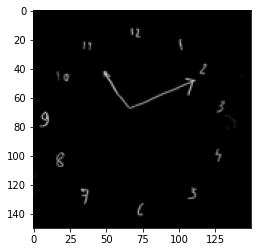

(176, 150, 150)


In [ ]:
# Using Deep learning
X = clock_image2.reshape((-1,150,150,1))
y = data.diagnosis
plt.imshow(clock_image2[0], cmap='gray',vmin=0, vmax=1)
plt.show()
print(clock_image2.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=1)

# 2.3.1 Model 1

In [ ]:
# Model 1 : Reference : https://www.youtube.com/watch?v=CM92pIh1Unw&ab_channel=IBMDeveloper (Cannot used)
inputs = Input(shape=(150, 150, 1))
x = Conv2D(32, (5, 5),padding='same',activation='relu')(inputs)
x = MaxPool2D((3, 3))(x)
x = Conv2D(64, (5, 5))(x)
x = MaxPool2D((3, 3))(x)
x = Flatten()(x)
output = Dense(1 ,activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 150, 150, 32)      832       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 46, 46, 64)        51264     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 14400)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)               

In [ ]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
5/5 [==============================] - 3s 630ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 2/10
5/5 [==============================] - 3s 607ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 3/10
5/5 [==============================] - 3s 613ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 4/10
5/5 [==============================] - 3s 626ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 5/10
5/5 [==============================] - 3s 624ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 6/10
5/5 [==============================] - 3s 615ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss: 0.0000e+00 - val_accuracy: 0.6970
Epoch 7/10
5/5 [==============================] - 3s 611ms/step - loss: 0.0000e+00 - accuracy: 0.5758 - val_loss

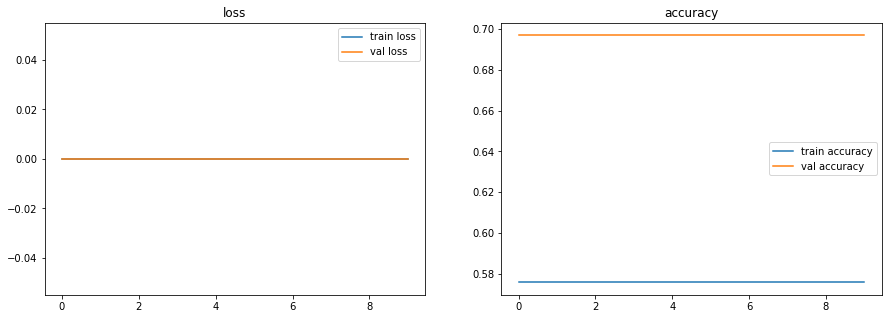

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history['loss'], label='train loss')
ax[0].plot(hist.epoch, hist.history['val_loss'], label='val loss')
ax[1].set_title('accuracy')
ax[1].plot(hist.epoch, hist.history['accuracy'], label='train accuracy')
ax[1].plot(hist.epoch, hist.history['val_accuracy'], label='val accuracy')
ax[0].legend()
ax[1].legend()

# 2.3.2 Model 2

In [ ]:
# Model 2 (Change compile loss and output activation)
x = Conv2D(16, (5, 5),padding='same',activation='relu')(inputs)
x = MaxPool2D((3, 3))(x)
x = Conv2D(32, (5, 5),padding='same',activation='relu')(x)
x = MaxPool2D((3, 3))(x)
x = Flatten()(x)
output = Dense(1 ,activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 150, 150, 16)      416       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 50, 50, 32)        12832     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 1)               

In [ ]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5/5 [==============================] - 2s 386ms/step - loss: 0.6807 - accuracy: 0.5303 - val_loss: 0.6187 - val_accuracy: 0.6970
Epoch 2/20
5/5 [==============================] - 2s 365ms/step - loss: 0.6450 - accuracy: 0.5909 - val_loss: 0.6139 - val_accuracy: 0.7273
Epoch 3/20
5/5 [==============================] - 2s 362ms/step - loss: 0.6272 - accuracy: 0.6970 - val_loss: 0.6450 - val_accuracy: 0.6970
Epoch 4/20
5/5 [==============================] - 2s 368ms/step - loss: 0.5900 - accuracy: 0.7955 - val_loss: 0.6384 - val_accuracy: 0.6667
Epoch 5/20
5/5 [==============================] - 2s 365ms/step - loss: 0.5384 - accuracy: 0.7803 - val_loss: 0.6036 - val_accuracy: 0.6667
Epoch 6/20
5/5 [==============================] - 2s 365ms/step - loss: 0.5153 - accuracy: 0.7803 - val_loss: 0.6279 - val_accuracy: 0.6970
Epoch 7/20
5/5 [==============================] - 2s 361ms/step - loss: 0.4716 - accuracy: 0.7955 - val_loss: 0.6719 - val_accuracy: 0.6061
Epoch 8/20
5/5 [====

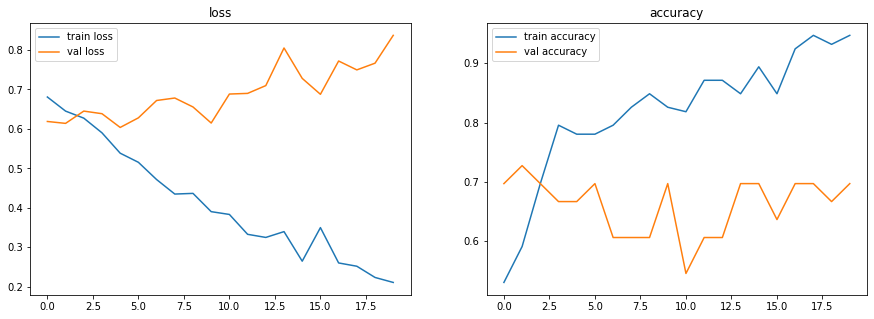

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history['loss'], label='train loss')
ax[0].plot(hist.epoch, hist.history['val_loss'], label='val loss')
ax[1].set_title('accuracy')
ax[1].plot(hist.epoch, hist.history['accuracy'], label='train accuracy')
ax[1].plot(hist.epoch, hist.history['val_accuracy'], label='val accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
y_pred = model.predict(X_test); # Overfit because train loss and val loss are very far
y_pred = y_pred>=0.5
print('Accuracy Score : '+str(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.6363636363636364


#2.3.3 Dropout Model (Reduce Overfit)

In [ ]:
# Model 3 : https://www.bualabs.com/archives/1533/what-is-dropout-benefits-dropout-reduce-overfit-deep-learning-training-model-deep-neural-network-regularization-ep-2/
# Using default value (0.5)
input = Input(shape=(150, 150, 1))
x = Conv2D(32, (5, 5),padding='same',activation='relu')(input)
x = MaxPool2D((3, 3))(x)
x = Conv2D(64, (5, 5),padding='same',activation='relu')(x)
x = MaxPool2D((3, 3))(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)
x = Dropout(0.5)(x)
output = Dense(1 ,activation='sigmoid')(x)
model = Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5/5 [==============================] - 3s 698ms/step - loss: 0.6835 - accuracy: 0.5379 - val_loss: 0.6039 - val_accuracy: 0.6970
Epoch 2/20
5/5 [==============================] - 3s 681ms/step - loss: 0.6520 - accuracy: 0.5758 - val_loss: 0.5897 - val_accuracy: 0.7273
Epoch 3/20
5/5 [==============================] - 3s 676ms/step - loss: 0.6139 - accuracy: 0.6515 - val_loss: 0.6306 - val_accuracy: 0.6970
Epoch 4/20
5/5 [==============================] - 3s 685ms/step - loss: 0.6017 - accuracy: 0.7576 - val_loss: 0.6571 - val_accuracy: 0.6061
Epoch 5/20
5/5 [==============================] - 3s 679ms/step - loss: 0.5511 - accuracy: 0.7727 - val_loss: 0.5962 - val_accuracy: 0.6970
Epoch 6/20
5/5 [==============================] - 3s 680ms/step - loss: 0.5104 - accuracy: 0.7576 - val_loss: 0.6523 - val_accuracy: 0.6970
Epoch 7/20
5/5 [==============================] - 3s 674ms/step - loss: 0.4781 - accuracy: 0.7727 - val_loss: 0.7012 - val_accuracy: 0.5758
Epoch 8/20
5/5 [====

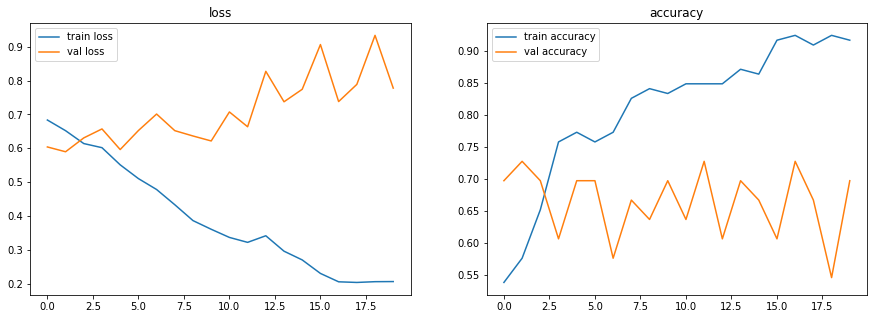

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history['loss'], label='train loss')
ax[0].plot(hist.epoch, hist.history['val_loss'], label='val loss')
ax[1].set_title('accuracy')
ax[1].plot(hist.epoch, hist.history['accuracy'], label='train accuracy')
ax[1].plot(hist.epoch, hist.history['val_accuracy'], label='val accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
y_pred = model.predict(X_test); # Less overfit
y_pred = y_pred>=0.5
print('Accuracy Score : '+str(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.7272727272727273


#2.3.4 Change Dropout Value = 0.75

In [ ]:
# Model 4 : Change dropout value (0.75)
input = Input(shape=(150, 150, 1))
x = Conv2D(32, (5, 5),padding='same',activation='relu')(input)
x = MaxPool2D((3, 3))(x)
x = Conv2D(64, (5, 5),padding='same',activation='relu')(x)
x = MaxPool2D((3, 3))(x)
x = Flatten()(x)
x = Dropout(0.75)(x)
output = Dense(1 ,activation='sigmoid')(x)
model = Model(inputs=input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
5/5 [==============================] - 3s 698ms/step - loss: 0.6849 - accuracy: 0.5682 - val_loss: 0.6171 - val_accuracy: 0.6970
Epoch 2/20
5/5 [==============================] - 3s 677ms/step - loss: 0.6584 - accuracy: 0.5758 - val_loss: 0.5935 - val_accuracy: 0.6970
Epoch 3/20
5/5 [==============================] - 3s 675ms/step - loss: 0.6318 - accuracy: 0.6288 - val_loss: 0.6126 - val_accuracy: 0.6970
Epoch 4/20
5/5 [==============================] - 3s 672ms/step - loss: 0.5961 - accuracy: 0.6970 - val_loss: 0.6005 - val_accuracy: 0.7273
Epoch 5/20
5/5 [==============================] - 3s 673ms/step - loss: 0.5603 - accuracy: 0.7500 - val_loss: 0.5886 - val_accuracy: 0.7576
Epoch 6/20
5/5 [==============================] - 3s 679ms/step - loss: 0.5475 - accuracy: 0.7197 - val_loss: 0.5970 - val_accuracy: 0.6970
Epoch 7/20
5/5 [==============================] - 3s 675ms/step - loss: 0.5068 - accuracy: 0.7500 - val_loss: 0.5814 - val_accuracy: 0.7576
Epoch 8/20
5/5 [====

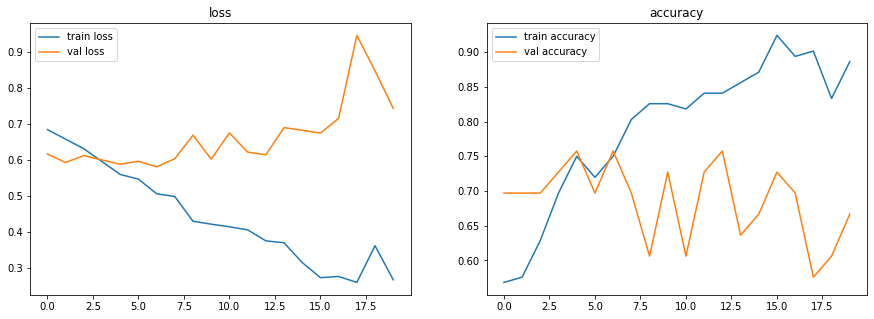

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history['loss'], label='train loss')
ax[0].plot(hist.epoch, hist.history['val_loss'], label='val loss')
ax[1].set_title('accuracy')
ax[1].plot(hist.epoch, hist.history['accuracy'], label='train accuracy')
ax[1].plot(hist.epoch, hist.history['val_accuracy'], label='val accuracy')
ax[0].legend()
ax[1].legend()

In [ ]:
y_pred = model.predict(X_test); # Less overfit
y_pred = y_pred>=0.5
print('Accuracy Score : '+str(accuracy_score(y_test, y_pred)))

Accuracy Score : 0.7272727272727273
